# Бинарная классификация текста

1. Подгрузка и предобработка текстов

2. Векторизация текстов

3. Обучение модели машинного/глубокого обучения

4. Подсчёт метрик**
- На этапе подсчёта метрик необходимо использовать F1, ROC AUC, а также необходимо нарисовать ROC кривую
5. Также в качестве дополнительной задачи нужно сделать модель, которая бы максимизировала метрику Recall.


In [48]:
# !pip install nltk
# !pip install catboost

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, recall_score, roc_curve

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Подгрузка и предобработка текстов.

## Подгрузка и EDA

In [56]:
data = pd.read_csv("SPAM text message 20170820 - Data.csv", encoding = 'latin1')
data.head(-1)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ã¼ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."


## варианты содержания текста

In [58]:
data.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

## Визуализация распределения категорий Spam and Ham

Text(0.5, 1.0, 'Распределение категорий Spam and Ham')

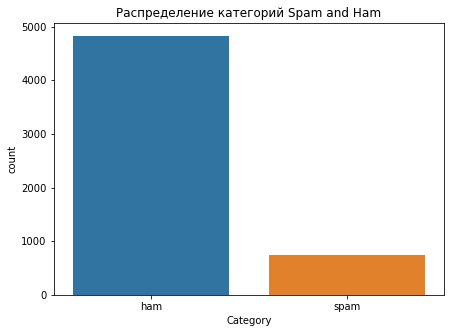

In [169]:
# Визуализация распределения категорий Spam and Ham
sns.countplot(x = "Category", data = data)
data.loc[:, 'Category'].value_counts()
plt.title('Распределение категорий Spam and Ham')

In [133]:
# Выявим ТОП 25 слов, которые чаще всего встречаются в категориях spam и ham.
ham = Counter(" ".join(data[data['Category']=='ham']["Message"]).split()).most_common(25)
data_ham = pd.DataFrame.from_dict(ham)
data_ham = data_ham.rename(columns={0: "words of ham", 1 : "count"})
spam = Counter(" ".join(data[data['Category']=='spam']["Message"]).split()).most_common(25)
data_spam = pd.DataFrame.from_dict(spam)
data_spam = data_spam.rename(columns={0: "words of spam", 1 : "count_"})

## ТОП 25 СЛОВ КАТЕГОРИИ ham

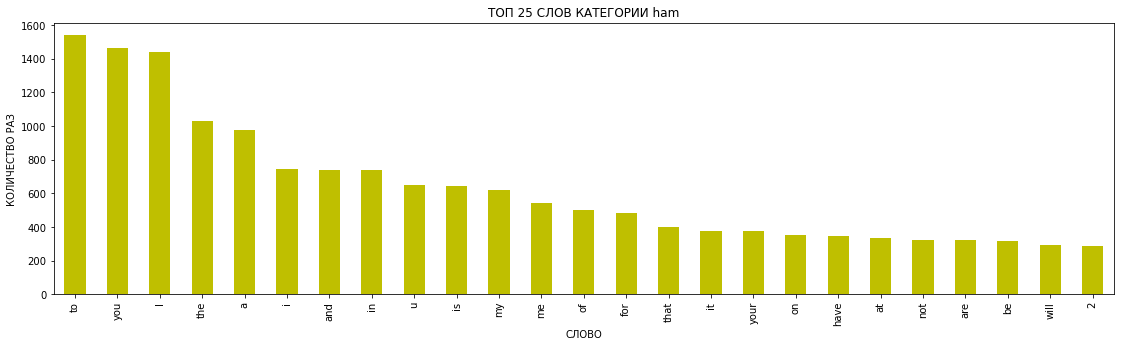

In [135]:
data_ham.plot.bar(legend = False, color = 'y',figsize = (19,5))
y_pos = np.arange(len(data_ham["words of ham"]))
plt.xticks(y_pos, data_ham["words of ham"])
plt.title('ТОП 25 СЛОВ КАТЕГОРИИ ham')
plt.xlabel('СЛОВО')
plt.ylabel('КОЛИЧЕСТВО РАЗ')
plt.show()

## ТОП 25 СЛОВ КАТЕГОРИИ spam

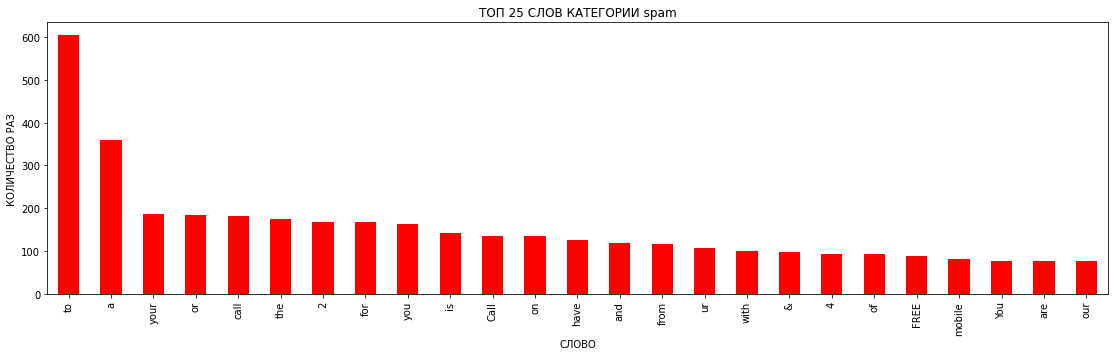

In [153]:
data2.plot.bar(legend = False, color = 'r', figsize = (19,5))
y_pos = np.arange(len(data2["words of spam"]))
plt.xticks(y_pos, data2["words of spam"])
plt.title('ТОП 25 СЛОВ КАТЕГОРИИ spam')
plt.xlabel('СЛОВО')
plt.ylabel('КОЛИЧЕСТВО РАЗ')
plt.show()

## Визуализация распределения по длине текста

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


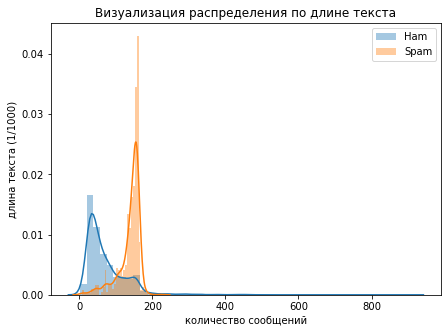

In [92]:
# Визуализация распределения по длине текста
ham =data[data['Category'] == 'ham']['Message'].str.len()
sns.distplot(ham, label='Ham')
spam = data[data['Category'] == 'spam']['Message'].str.len()
sns.distplot(spam, label='Spam')
plt.title('Визуализация распределения по длине текста')
plt.xlabel('количество сообщений')
plt.ylabel('длина текста (1/1000)')
plt.legend()

## Визуализация распределения текста, содержащего цифры

/tmp/ipykernel_229/968218917.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  ham1 = data[data['Category'] == 'ham']['Message'].str.replace(r'\D+', '').str.len()
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/tmp/ipykernel_229/968218917.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  spam1 = data[data['Category'] == 'spam']['Message'].str.replace(r'\D+', '').str.len()
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figur

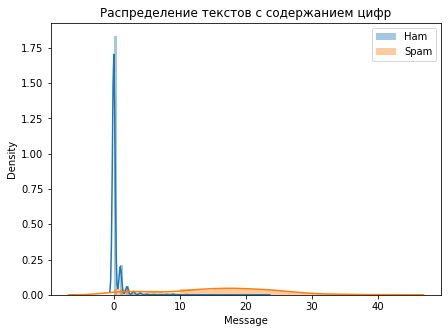

In [176]:
# Визуализация распределения текста, содержащего цифры
ham1 = data[data['Category'] == 'ham']['Message'].str.replace(r'\D+', '').str.len()
sns.distplot(ham1, label='Ham')
spam1 = data[data['Category'] == 'spam']['Message'].str.replace(r'\D+', '').str.len()
sns.distplot(spam1, label='Spam')
plt.title('Распределение текстов с содержанием цифр')
plt.legend()

## Визуализация распределения текста, не содержащего цифры

/tmp/ipykernel_229/2486514767.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  ham2 = data[data['Category'] == 'ham']['Message'].str.replace(r'\w+', '').str.len()
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/tmp/ipykernel_229/2486514767.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  spam2 = data[data['Category'] == 'spam']['Message'].str.replace(r'\w+', '').str.len()
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fig

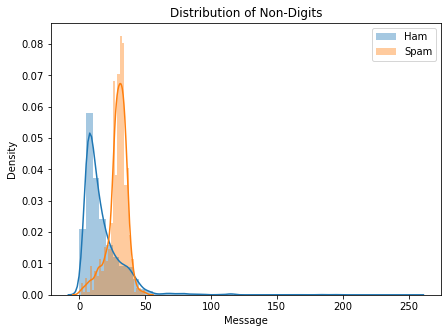

In [175]:
# Визуализация распределения текста, содержащего цифры

ham2 = data[data['Category'] == 'ham']['Message'].str.replace(r'\w+', '').str.len()
sns.distplot(ham2, label='Ham')
spam2 = data[data['Category'] == 'spam']['Message'].str.replace(r'\w+', '').str.len()
sns.distplot(spam2, label='Spam')
plt.title('Distribution of Non-Digits')
plt.legend()

## Векторизация текста

In [139]:
# функция векторизации текста
def vectorization(X_train, X_test):
    cv = CountVectorizer(max_features=1500)
    cv.fit(X_train)
    X_train_cv = cv.transform(X_train)
    X_test_cv = cv.transform(X_test)
    return X_train_cv, X_test_cv

# 2. Предобработка данных текста, векторизация и получение конечных тестового/тренировочного наборов

In [140]:
# функция для предобработки текста, разбивки на тестовые и тренировочные данные
def preprocess(data):
    X_train, X_test, y_train, y_test = train_test_split(data['Message'], data['Category'],
                                                        test_size=0.3, random_state=37)
    corpus = []
    for i in range(0, 5572):
        review = re.sub('[^a-zA-Z]', ' ', data['Message'][i])
        review = review.lower()
        review = review.split()
        ps = PorterStemmer()
        review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
    
    # этап векторизации текста
    X_train_cv, X_test_cv = vectorization(X_train, X_test)   
    
    return X_train_cv, X_test_cv, y_train, y_test



## Получение окончательных тестового и тренировочного наборов

In [141]:
X_train, X_test, y_train, y_test = preprocess(data)

# 3. Обучение моделей, метрик и графика визуализации площади под ошибками

## подготовим список моделей, которые будем использовать

In [142]:
# список моделей для построения
models = {
    'Cat Boost Classification': CatBoostClassifier(n_estimators=37, random_state=252, silent=True),
    'Decision tree Classification': DecisionTreeClassifier(min_samples_split=7, random_state=252),
    'Naive Bayes Classification': MultinomialNB(alpha = 0.5),
    'Random Forest Classification': RandomForestClassifier(n_estimators=37, random_state=252),
    'Bagging Classification': BaggingClassifier(n_estimators=9, random_state=252),
    'KNeighbors Classification': KNeighborsClassifier(n_neighbors=100),
    'Extra Tree Classification': ExtraTreesClassifier(n_estimators=37, random_state=252),
    'Adaptive Boost Classification': AdaBoostClassifier(n_estimators=37, random_state=252)
            }

In [143]:
# функция визуализации графика roc-curve
def plot_cor_curve(y_test, y_pred, pos_label, model_name):
    fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label=pos_label)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.title(model_name)
    plt.show()

In [144]:
# функция подсчета метрик F1, ROC AUC, а также recall
def print_metrics(y_test, y_pred, y_pred_proba, model_name):
    roc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_pred, y_test, average="macro")
    rec = recall_score(y_pred, y_test, average="macro")
    print(f'{model_name} roc auc: {roc}, f1_score: {f1}, recall: {rec}')
    return rec

In [145]:
# функция построения модели, вывода результата оценки и визуализация roc-кривой
def build_model(models, X_train,y_train, X_test, y_test):
    recalls = {}
    for name, model in models.items():
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        y_predict_proba = model.predict_proba(X_test)
        print(f'{name} metrics:')
        rec = print_metrics(y_test, y_pred, y_predict_proba[:,1], name)
        recalls[name] = rec
        plot_cor_curve(y_test, y_predict_proba[:, 1], 'spam', name)
    return recalls

# Результаты работы моделей в метриках и графиках roc-кривой

Cat Boost Classification metrics:
Cat Boost Classification roc auc: 0.9851315176908751, f1_score: 0.9525852984074259, recall: 0.9792276925172981


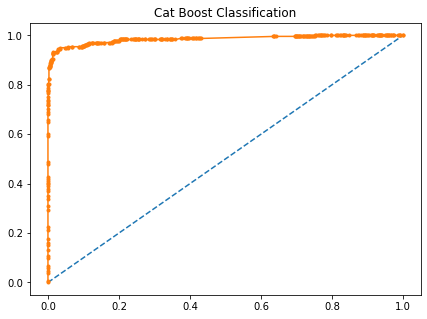

Decision tree Classification metrics:
Decision tree Classification roc auc: 0.9416753957169461, f1_score: 0.9340938488176194, recall: 0.9356152502842141


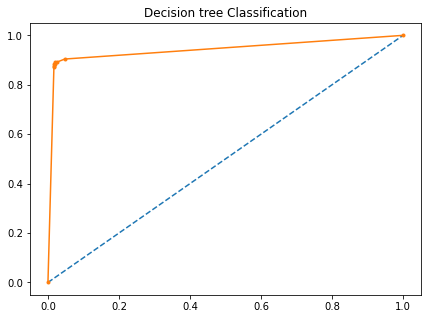

Naive Bayes Classification metrics:
Naive Bayes Classification roc auc: 0.9950506284916201, f1_score: 0.9669893584115932, recall: 0.9694570634675606


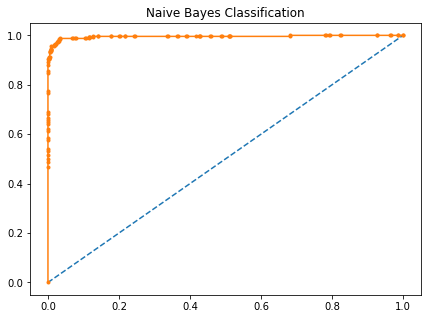

Random Forest Classification metrics:
Random Forest Classification roc auc: 0.9891861615456239, f1_score: 0.9518621663114533, recall: 0.9874063989108237


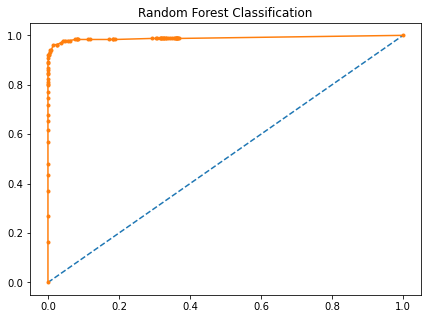

Bagging Classification metrics:
Bagging Classification roc auc: 0.9792961475791434, f1_score: 0.9434628559667153, recall: 0.9482246234680171


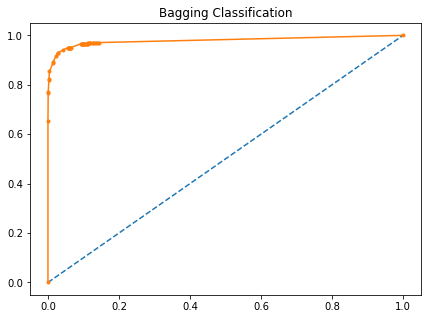

KNeighbors Classification metrics:
KNeighbors Classification roc auc: 0.9090229283054003, f1_score: 0.46134020618556704, recall: 0.42822966507177035


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


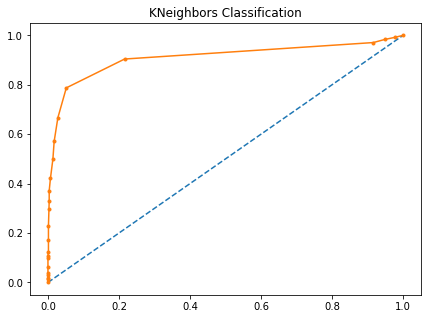

Extra Tree Classification metrics:
Extra Tree Classification roc auc: 0.9924013617318437, f1_score: 0.961483529140751, recall: 0.9897400820793434


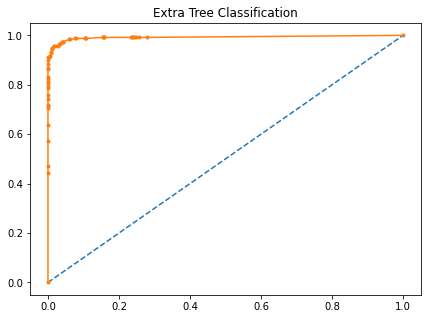

Adaptive Boost Classification metrics:
Adaptive Boost Classification roc auc: 0.9765872323091248, f1_score: 0.9309293871406015, recall: 0.9552985267510985


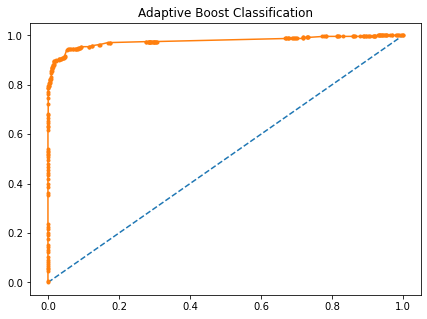

In [149]:
recalls = build_model(models, X_train, y_train, X_test, y_test)


# Модель с максимальной метрикой recall

In [151]:
# recall максимизирует модель:
print(f'Модель {list(recalls.keys())[list(recalls.values()).index(max(recalls.values()))]} '
      f'имеет максимальную recall_score : {round(max(recalls.values()), 2)}')

Модель Extra Tree Classification имеет максимальную recall_score : 0.99


# Модель Extra Tree Classification имеет максимальную recall_score : 0.99